### Load from tracklet images

[0 1 2 3 4 6 7]
['images', 'dimensions', 'positions', 'frame_segment_indexes', 'tracklets', 'frames', 'ids', 'encoding']
(217, 80, 80, 1)


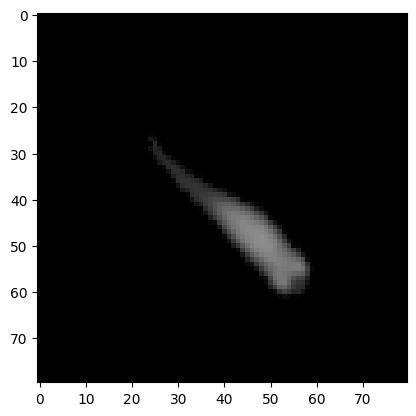

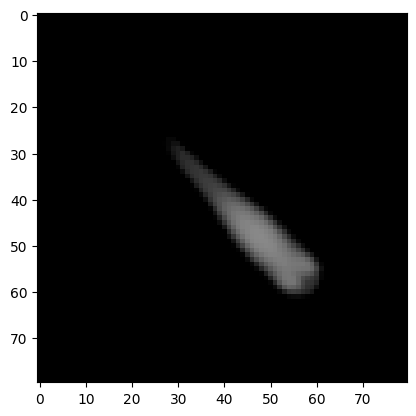

(100, 80, 80, 1)
(100,)


In [1]:
# load sample image files
import numpy as np
import matplotlib.pyplot as plt

# Load the image files

from glob import glob

all_images = []
all_ids = []

for file in glob("/Users/tristan/Downloads/data/guppy_8_t56_d1_20200727_092850_tracklet_images_single_part*.npz"):
    with np.load(file) as data:
        images = data["images"]
        ids = data["ids"]
        print(np.unique(ids))
        print(data.files)
        print(images.shape)

        # sample 100 images from each file
        indexes = np.random.choice(images.shape[0], 100, replace=False)
        images = images[indexes]
        ids = ids[indexes]

        all_images.append(images)
        all_ids.append(ids)

        # display example image
        plt.imshow(images[0], vmin=0, vmax=255, cmap='gray')
        plt.show()

        # display median image
        plt.imshow(np.median(images, axis=0), vmin=0, vmax=255, cmap='gray')
        plt.show()

all_images = np.concatenate(all_images)
all_ids = np.concatenate(all_ids)

print(all_images.shape)
print(all_ids.shape)



### Load from validation_data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

all_images = []
all_ids = []

with np.load("/Users/tristan/Downloads/guppy_8_t56_d1_20200727_092850_validation_data.npz") as data:
    print(data.files)
    images = data["images"]
    ids = data["ids"]
    print(np.unique(ids))
    print(data.files)
    print(images.shape)

    # sample 100 images from each file
    indexes = np.random.choice(images.shape[0], 100, replace=False)
    images = images[indexes]
    ids = ids[indexes]

    all_images.append(images)
    all_ids.append(ids)

    # display example image
    plt.imshow(images[0], vmin=0, vmax=255, cmap='gray')
    plt.show()

    # display median image
    plt.imshow(np.median(images, axis=0), vmin=0, vmax=255, cmap='gray')
    plt.show()

all_images = np.concatenate(all_images)
all_ids = np.concatenate(all_ids)

print(all_images.shape)
print(all_ids.shape)


### Some Tests for creating a custom PyTorch

In [55]:
# %% [code]
import json
import numpy as np
import torch
import torch.nn as nn

# Custom layer that mimics the Keras Lambda scaling layer: (x / 127.5 - 1.0)
class ColorScaling(nn.Module):
    def __init__(self):
        super(ColorScaling, self).__init__()

    def forward(self, x):
        return x / 127.5 - 1.0

# Dynamic model builder from Keras JSON configuration.
# Assumes the model was originally defined for channels-first inputs.
class DynamicKeras2Torch(nn.Module):
    def __init__(self, keras_config, dummy_input_shape=(1, 1, 80, 80)):
        """
        keras_config: dict loaded from the Keras JSON file.
        dummy_input_shape: expected input shape in channels-first order (N, C, H, W)
        """
        super(DynamicKeras2Torch, self).__init__()
        self.layer_list = []
        self.weight_layers = []  # List of layers that have learnable weights (Conv2D and Dense)

        # Set initial number of channels
        current_channels = dummy_input_shape[1]
        
        # Loop through the Keras layers as defined in the JSON config.
        for layer in keras_config["config"]["layers"]:
            class_name = layer["class_name"]
            cfg = layer["config"]
            # We ignore the Keras layer name since weights come in order.
            if class_name == "Lambda":
                # Replace Lambda with our ColorScaling layer.
                module = ColorScaling()
                print("Replacing Lambda layer with ColorScaling at index", len(self.layer_list))
                self.layer_list.append(module)
            elif class_name == "Conv2D":
                filters = cfg["filters"]
                kernel_size = tuple(cfg["kernel_size"])
                strides = tuple(cfg["strides"])
                padding = cfg["padding"]
                # Use an approximation for 'same' padding: half the kernel size.
                pad = kernel_size[0] // 2 if padding == "same" else 0
                module = nn.Conv2d(
                    in_channels=current_channels,
                    out_channels=filters,
                    kernel_size=kernel_size,
                    stride=strides,
                    padding=pad,
                    bias=cfg.get("use_bias", True)
                )
                self.layer_list.append(module)
                self.weight_layers.append(module)
                current_channels = filters
            elif class_name == "MaxPooling2D":
                pool_size = tuple(cfg["pool_size"])
                strides = tuple(cfg["strides"])
                module = nn.MaxPool2d(kernel_size=pool_size, stride=strides)
                self.layer_list.append(module)
            elif class_name == "SpatialDropout2D":
                rate = cfg["rate"]
                module = nn.Dropout2d(rate)
                self.layer_list.append(module)
            elif class_name == "Flatten":
                module = nn.Flatten()
                self.layer_list.append(module)
            elif class_name == "Dense":
                units = cfg["units"]
                # Create a placeholder Linear layer; we’ll update its in_features later.
                module = nn.Linear(1, units)
                self.layer_list.append(module)
                self.weight_layers.append(module)
            elif class_name == "Dropout":
                rate = cfg["rate"]
                module = nn.Dropout(rate)
                self.layer_list.append(module)
            elif class_name == "Activation":
                act = cfg["activation"]
                if act == "softmax":
                    module = nn.Softmax(dim=1)
                elif act == "relu":
                    module = nn.ReLU()
                else:
                    raise NotImplementedError(f"Activation '{act}' not implemented")
                self.layer_list.append(module)
            else:
                raise NotImplementedError(f"Layer type '{class_name}' not implemented in this converter.")

        # Create the sequential model.
        self.model = nn.Sequential(*self.layer_list)
        # Use a dummy forward pass to update Dense layers with the correct in_features.
        self._update_dense_layers(dummy_input_shape)

    def _update_dense_layers(self, dummy_input_shape):
        # Create a dummy input tensor.
        dummy_input = torch.zeros(dummy_input_shape, dtype=torch.float32)
        x = dummy_input
        new_modules = []
        for module in self.model:
            # If the module is a placeholder Linear layer (in_features==1), update it.
            if isinstance(module, nn.Linear) and module.in_features == 1:
                in_features = x.view(x.size(0), -1).size(1)
                new_linear = nn.Linear(in_features, module.out_features, bias=(module.bias is not None))
                new_modules.append(new_linear)
                module = new_linear  # Use the updated layer for the subsequent pass.
            else:
                new_modules.append(module)
            x = module(x)
        # Update the model.
        self.model = nn.Sequential(*new_modules)
        self.layer_list = list(self.model)
        # Re-scan to update weight_layers: we want all Conv2d and Linear layers.
        self.weight_layers = [layer for layer in self.model if isinstance(layer, (nn.Conv2d, nn.Linear))]

    def forward(self, x):
        return self.model(x)

# Function to load weights from the NPZ file into the PyTorch model.
# The NPZ file contains a single key "weights", whose value is a dict mapping layer indexes
# (as strings) to a list of parameters. For Conv2D layers, the list is [kernel, bias],
# and for Dense layers it is [kernel, bias]. Kernels need to be transposed.
def load_keras_weights(pt_model, weights_npz):
    weight_map = weights_npz["weights"].item()  # Extract the weights dictionary.
    # Sort keys numerically.
    sorted_keys = sorted(weight_map.keys(), key=lambda x: int(x))
    for i, key in enumerate(sorted_keys):
        layer_weights = weight_map[key]
        layer = pt_model.weight_layers[i]
        print(f"Loading weights for layer {i} (key: {key}, type: {type(layer)})")
        if isinstance(layer_weights, (list, tuple)):
            if isinstance(layer, nn.Conv2d):
                # Transpose kernel from (H, W, in_channels, out_channels) to (out_channels, in_channels, H, W)
                kernel = np.transpose(layer_weights[0], (3, 2, 0, 1))
                layer.weight.data.copy_(torch.from_numpy(kernel))
                if len(layer_weights) > 1 and layer.bias is not None:
                    layer.bias.data.copy_(torch.from_numpy(layer_weights[1]))
            elif isinstance(layer, nn.Linear):
                # Transpose kernel from (in_features, out_features) to (out_features, in_features)
                kernel = np.transpose(layer_weights[0], (1, 0))
                layer.weight.data.copy_(torch.from_numpy(kernel))
                if len(layer_weights) > 1 and layer.bias is not None:
                    layer.bias.data.copy_(torch.from_numpy(layer_weights[1]))
            else:
                print(f"Warning: Weight loading not implemented for layer type {type(layer)} at index {i}")
        else:
            print(f"Unexpected weight format for layer {i}: {type(layer_weights)}")

# %% [code]
# Specify the file paths (adjust as needed)
json_path = '/Users/tristan/Downloads/guppy_8_t56_d1_20200727_092850_weights.json'
npz_path = '/Users/tristan/Downloads/guppy_8_t56_d1_20200727_092850_weights.npz'

# Load the Keras model configuration.
with open(json_path, 'r') as f:
    keras_config = json.load(f)

# Load the weights NPZ file (allow_pickle=True since "weights" is a dict).
weights_npz = np.load(npz_path, allow_pickle=True)

# Build the PyTorch model.
pt_model = DynamicKeras2Torch(keras_config, dummy_input_shape=(1, 1, 80, 80))

# Load the weights into the model.
load_keras_weights(pt_model, weights_npz)

# Set the model to evaluation mode.
pt_model.eval()

# Test the model with a dummy input (channels-first).
dummy_input = torch.zeros((1, 1, 80, 80), dtype=torch.float32)
output = pt_model(dummy_input)
print("Model output shape:", output.shape)

Replacing Lambda layer with ColorScaling at index 0
Loading weights for layer 0 (key: 1, type: <class 'torch.nn.modules.conv.Conv2d'>)
Loading weights for layer 1 (key: 4, type: <class 'torch.nn.modules.conv.Conv2d'>)
Loading weights for layer 2 (key: 7, type: <class 'torch.nn.modules.conv.Conv2d'>)
Loading weights for layer 3 (key: 11, type: <class 'torch.nn.modules.linear.Linear'>)
Loading weights for layer 4 (key: 13, type: <class 'torch.nn.modules.linear.Linear'>)
Model output shape: torch.Size([1, 8])


In [56]:
pt_model

DynamicKeras2Torch(
  (model): Sequential(
    (0): ColorScaling()
    (1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.25, inplace=False)
    (4): Conv2d(16, 64, kernel_size=(5, 5), stride=(1, 1))
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Dropout2d(p=0.25, inplace=False)
    (7): Conv2d(64, 100, kernel_size=(5, 5), stride=(1, 1))
    (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=3600, out_features=100, bias=True)
    (12): Dropout(p=0.5, inplace=False)
    (13): Linear(in_features=100, out_features=8, bias=True)
  )
)

In [101]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# -----------------------------
# Model Definition
# -----------------------------
class InputScaling(nn.Module):
    """
    Mimics the Keras Lambda layer: scales input as (x/127.5 - 1.0).
    """
    def __init__(self):
        super(InputScaling, self).__init__()
        
    def forward(self, x):
        return x / 127.5 - 1.0

class V100Model(nn.Module):
    def __init__(self, image_width, image_height, channels, num_classes, padding='valid'):
        """
        Constructs a PyTorch model equivalent to your Keras v100 model.
        
        Parameters:
          image_width, image_height: dimensions of input images.
          channels: number of input channels (e.g. 1 for grayscale, 3 for RGB).
          num_classes: number of output classes.
          padding: use 'valid' for no padding (default) or 'same' for preserving spatial dims.
        """
        super(V100Model, self).__init__()
        self.input_scaling = InputScaling()
        
        # Choose padding value: for a 5x5 kernel, 'same' means padding=2.
        pad = 0 if padding == 'valid' else 2
        
        # Block 1: Conv2D(16,5, activation='relu') → MaxPooling2D(2x2) → SpatialDropout2D(0.25)
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=16, kernel_size=5, padding=pad)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop1 = nn.Dropout2d(0.25)
        
        # Block 2: Conv2D(64,5, activation='relu') → MaxPooling2D(2x2) → SpatialDropout2D(0.25)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=5, padding=pad)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop2 = nn.Dropout2d(0.25)
        
        # Block 3: Conv2D(100,5, activation='relu') → MaxPooling2D(2x2) → SpatialDropout2D(0.25)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=100, kernel_size=5, padding=pad)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop3 = nn.Dropout2d(0.25)
        
        # The Flatten layer is explicit.
        self.flatten = nn.Flatten()
        
        # To set up the first fully-connected layer, we need to know the flattened size.
        # We perform a dummy forward pass.
        dummy = torch.zeros((1, channels, image_height, image_width))
        dummy = self._forward_conv(dummy)
        fc_input_dim = dummy.view(dummy.size(0), -1).size(1)
        print(f"Computed fc_input_dim: {fc_input_dim}")
        
        # Dense layers: Dense(100, activation='relu') → Dropout(0.5) → Dense(num_classes, activation='softmax')
        self.fc1 = nn.Linear(fc_input_dim, 100)
        self.relu_fc1 = nn.ReLU()
        self.drop_fc1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(100, num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def _forward_conv(self, x):
        # Convolutional part of the network.
        x = self.input_scaling(x)
        
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.drop1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.drop2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.drop3(x)
        
        return x

    def forward(self, x):
        x = self._forward_conv(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu_fc1(x)
        x = self.drop_fc1(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# -----------------------------
# Weight Loading Function
# -----------------------------
def load_weights_pt(model, weights_dict):
    """
    Loads weights saved in a dictionary (keys corresponding to the Keras layer index)
    into the corresponding layers of the PyTorch model.
    
    Expected mapping (from the Keras saving code):
      - Key 1: Conv2D(16,5) weights → model.conv1
      - Key 4: Conv2D(64,5) weights → model.conv2
      - Key 7: Conv2D(100,5) weights → model.conv3
      - Key 11: Dense(100) weights → model.fc1
      - Key 13: Dense(num_classes) weights → model.fc2
    """
    mapping = {
        1: model.conv1,
        4: model.conv2,
        7: model.conv3,
        11: model.fc1,
        13: model.fc2
    }
    for k, layer in mapping.items():
        wlist = weights_dict[k]
        print(f"Loading weights for Keras layer {k} into {layer}")
        if isinstance(layer, nn.Conv2d):
            # Keras Conv2D kernel shape: (H, W, in_channels, out_channels)
            # PyTorch expects: (out_channels, in_channels, H, W)
            kernel = np.transpose(wlist[0], (3, 2, 0, 1))
            layer.weight.data.copy_(torch.from_numpy(kernel))
            if len(wlist) > 1 and layer.bias is not None:
                layer.bias.data.copy_(torch.from_numpy(wlist[1]))
        elif isinstance(layer, nn.Linear):
            # Keras Dense kernel shape: (in_features, out_features)
            # PyTorch expects: (out_features, in_features)
            kernel = np.transpose(wlist[0], (1, 0))
            layer.weight.data.copy_(torch.from_numpy(kernel))
            if len(wlist) > 1 and layer.bias is not None:
                layer.bias.data.copy_(torch.from_numpy(wlist[1]))
        else:
            print(f"Warning: Not implemented for layer type {type(layer)}")

# -----------------------------
# Example Usage
# -----------------------------
# Assume you have saved weights using code similar to:
#   weights = {}
#   for i, layer in enumerate(model.layers):
#       h = layer.get_weights()
#       if len(h) > 0:
#           weights[i] = h
# and then saved to an NPZ file with key "weights".
# For example:
#   np.savez('model_weights.npz', weights=np.array(weights, dtype='object'))

# Load the saved weights dictionary from the NPZ file.
json_path = '/Users/tristan/Downloads/guppy_8_t56_d1_20200727_092850_weights.json'
npz_path = '/Users/tristan/Downloads/guppy_8_t56_d1_20200727_092850_weights.npz'
weights_npz = np.load(npz_path, allow_pickle=True)
saved_weights = weights_npz["weights"].item()
print("Saved weight keys:", saved_weights.keys())

# Set model parameters.
image_width = 80
image_height = 80
channels = 1       # Change to 3 if RGB
num_classes = 8

# Create the PyTorch model. For "same" padding, set padding='same'; for valid, use 'valid'.
model = V100Model(image_width, image_height, channels, num_classes, padding='valid')
model.eval()

# Load the weights into the model.
load_weights_pt(model, saved_weights)

# To predict, ensure your input images are a float tensor with shape (N, C, H, W)
# and pixel values in the [0, 255] range.
dummy_input = torch.zeros((1, channels, image_height, image_width), dtype=torch.float32)
output = model(dummy_input)
print("Model output shape:", output.shape)
print("Predicted probabilities:", output.detach().cpu().numpy())


Saved weight keys: dict_keys([1, 4, 7, 11, 13])
Computed fc_input_dim: 3600
Loading weights for Keras layer 1 into Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
Loading weights for Keras layer 4 into Conv2d(16, 64, kernel_size=(5, 5), stride=(1, 1))
Loading weights for Keras layer 7 into Conv2d(64, 100, kernel_size=(5, 5), stride=(1, 1))
Loading weights for Keras layer 11 into Linear(in_features=3600, out_features=100, bias=True)
Loading weights for Keras layer 13 into Linear(in_features=100, out_features=8, bias=True)
Model output shape: torch.Size([1, 8])
Predicted probabilities: [[0.05018484 0.1766188  0.12546952 0.13731201 0.06452174 0.07542665
  0.1994435  0.17102294]]


In [102]:
model

V100Model(
  (input_scaling): InputScaling()
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout2d(p=0.25, inplace=False)
  (conv2): Conv2d(16, 64, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout2d(p=0.25, inplace=False)
  (conv3): Conv2d(64, 100, kernel_size=(5, 5), stride=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout2d(p=0.25, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3600, out_features=100, bias=True)
  (relu_fc1): ReLU()
  (drop_fc1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=100, out_features=8, bias=True)
  (softmax): Softmax(dim=1)
)

In [ ]:
# predict the images
from tqdm import tqdm

predictions = []
model.eval()

with torch.no_grad():

    for image in tqdm(all_images):
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0) # shape: [1, 80, 80, 1]
        image = image.permute(0, 3, 1, 2)  # now shape: [1, 1, 80, 80]

        prediction = model(image)

        # apply softmax
        #prediction = nn.Softmax(dim=1)(
        #    prediction
        #)

        predictions.append(prediction.detach().numpy())

predictions = np.concatenate(predictions)
print(predictions.shape)

# for each id of unique ids, get the average prediction
unique_ids = np.unique(all_ids)
average_predictions = []

for id in unique_ids:
    indexes = np.where(all_ids == id)
    average_prediction = np.mean(predictions[indexes], axis=0)
    average_predictions.append(average_prediction)

average_predictions = np.array(average_predictions)
print(average_predictions)

for i, id in enumerate(unique_ids):
    plt.plot(average_predictions[i], label=id)
plt.legend()

100%|██████████| 100/100 [00:00<00:00, 366.59it/s]

(100, 8)


### Load TF model from JSON file

In [2]:
import keras
from keras.layers import Dense, Dropout, Activation, Cropping2D, Flatten, Convolution1D, Convolution2D, MaxPooling1D,MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Cropping2D, Flatten, Convolution1D, Convolution2D, MaxPooling1D,MaxPooling2D, Lambda
from keras.layers import SpatialDropout2D
from keras.models import Sequential
import json

classes = [0,1,2,3,4,5,6,7]
image_width = 80
image_height = 80
learning_rate = 0.001

'''def reinitialize_network():
    global model, image_width, image_height, classes, learning_rate
    model = Sequential()
    print("initializing network:"+str(image_width)+","+str(image_height)+" "+str(len(classes))+" classes")

    model.add(Lambda(lambda x: (x / 127.5 - 1.0), input_shape=(int(image_width),int(image_height),1)))
    model.add(Convolution2D(16, 5, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(SpatialDropout2D(0.25))
    #model.add(Dropout(0.5))

    model.add(Convolution2D(64, 5, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(SpatialDropout2D(0.25))
    #model.add(Dropout(0.5))

    model.add(Convolution2D(100, 5, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(SpatialDropout2D(0.25))
    #model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(classes), activation='softmax'))

    model.compile(loss='categorical_crossentropy',
            optimizer=keras.optimizers.Adam(lr=learning_rate),
            metrics=['accuracy'])
    return model

tf_model = reinitialize_network()
tf_model.summary()'''

from keras.models import model_from_json

def scaling_fn(x):
    return x / 127.5 - 1.0

# Load the JSON file into a dictionary.
json_path = "/Users/tristan/Downloads/guppy_8_t56_d1_20200727_092850_weights.json"
with open(json_path, "r") as f:
    model_dict = json.load(f)

# Replace the Lambda function configuration.
for layer in model_dict["config"]["layers"]:
    if layer["class_name"] == "Lambda":
        # Replace the marshaled function with our custom function name.
        layer["config"]["function"] = "scaling_fn"
        # Optionally, update the function type. Here we use "raw" so that
        # the custom function is looked up in custom_objects.
        layer["config"]["function_type"] = "raw"
        # You can also clear out any arguments if needed:
        layer["config"]["arguments"] = {}


# Load the model with the custom object for the lambda
new_json = json.dumps(model_dict)

# Load the model from the modified JSON using custom_objects.
tf_model = model_from_json(new_json, custom_objects={"scaling_fn": scaling_fn})
tf_model.compile(loss='categorical_crossentropy',
            optimizer=keras.optimizers.Adam(lr=learning_rate),
            metrics=['accuracy'])
tf_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 80, 80, 1)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 76, 76, 16)        416       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 38, 38, 16)        0         
 g2D)                                                            
                                                                 
 spatial_dropout2d_1 (Spati  (None, 38, 38, 16)        0         
 alDropout2D)                                                    
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        25664     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 64)       

#### Load weights from npz file

In [3]:
import numpy as np
with np.load('/Users/tristan/Downloads/guppy_8_t56_d1_20200727_092850_weights.npz', allow_pickle=True) as npz:
    weights = npz['weights'].item()
    for i, layer in zip(range(len(tf_model.layers)), tf_model.layers):
        if i in weights:
            layer.set_weights(weights[i])

### Convert tf_model to ONNX

In [4]:
import tensorflow as tf
import tf2onnx

# Assuming tf_model is your loaded TensorFlow/Keras model
spec = (tf.TensorSpec(tf_model.input.shape, tf.float32, name="input"),)
#output_path = "model.onnx"
onnx_model, _ = tf2onnx.convert.from_keras(tf_model, input_signature=spec)#, output_path=output_path)
print("Model successfully saved to ONNX format at.")

Model successfully saved to ONNX format at.


### Convert ONNX to PyTorch -> JIT

In [7]:
import onnx
from onnx2pytorch import ConvertModel
import torch

# ------------------------------
# Step 1: Convert ONNX to PyTorch
# ------------------------------

# Load the ONNX model from file (make sure 'model.onnx' exists)
#onnx_model = onnx.load("model.onnx")

# Convert the ONNX model to a PyTorch model
pytorch_model = ConvertModel(onnx_model)
pytorch_model.to('cpu')  # or 'cuda' if available
pytorch_model.eval()

print("Converted PyTorch model:")
print(pytorch_model)

# ------------------------------
# Step 2: Freeze the Model with TorchScript
# ------------------------------

# Define a dummy input with the proper dimensions.
# Adjust the dimensions (batch, channels, height, width) as needed.
dummy_input = torch.randn(1, 1, 80, 80)

# Try to script the model.
# If the model is not fully scriptable (e.g., contains dynamic control flow),
# fallback to tracing.
try:
    scripted_model = torch.jit.script(pytorch_model)
    print("Model scripted successfully.")
except Exception as e:
    print("Scripting failed, falling back to tracing. Error:", e)
    scripted_model = torch.jit.trace(pytorch_model, dummy_input)
    print("Model traced successfully.")

# Save the TorchScript model to disk.
scripted_model_path = "model_scripted.pt"
torch.jit.save(scripted_model, scripted_model_path)
print(f"TorchScript model saved at: {scripted_model_path}")

Converted PyTorch model:
ConvertModel(
  (Mul_sequential_1/lambda_1/truediv:0): sub()
  (Sub_sequential_1/lambda_1/sub:0): sub()
  (Reshape_sequential_1/conv2d_1/BiasAdd__6:0): Reshape(shape=[-1  1 80 80])
  (Conv_sequential_1/conv2d_1/BiasAdd:0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (Relu_sequential_1/conv2d_1/Relu:0): ReLU(inplace=True)
  (MaxPool_sequential_1/max_pooling2d_1/MaxPool:0): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (Conv_sequential_1/conv2d_2/BiasAdd:0): Conv2d(16, 64, kernel_size=(5, 5), stride=(1, 1))
  (Relu_sequential_1/conv2d_2/Relu:0): ReLU(inplace=True)
  (MaxPool_sequential_1/max_pooling2d_2/MaxPool:0): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (Conv_sequential_1/conv2d_3/BiasAdd:0): Conv2d(64, 100, kernel_size=(5, 5), stride=(1, 1))
  (Relu_sequential_1/conv2d_3/Relu:0): ReLU(inplace=True)
  (MaxPool_sequential_1/max_pooling2d_3/MaxPool:0): MaxPool2d(kernel_s

### Test JIT model

In [11]:
# ------------------------------
# Step 3: Load and Test the Frozen Model
# ------------------------------

# In a different environment (or later in your code), load the model without needing onnx2pytorch:
loaded_model = torch.jit.load(scripted_model_path)
loaded_model.eval()

# Test the loaded model with a dummy input.
with torch.no_grad():
    test_input = torch.randn(1, 1, 80, 80)  # Ensure this matches your model's expected shape.
    output = loaded_model(test_input)

print("Loaded model output:", output)
loaded_model.to('mps')

Loaded model output: tensor([[0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])


RecursiveScriptModule(
  original_name=ConvertModel
  (Mul_sequential_1/lambda_1/truediv:0): RecursiveScriptModule(original_name=sub)
  (Sub_sequential_1/lambda_1/sub:0): RecursiveScriptModule(original_name=sub)
  (Reshape_sequential_1/conv2d_1/BiasAdd__6:0): RecursiveScriptModule(original_name=Reshape)
  (Conv_sequential_1/conv2d_1/BiasAdd:0): RecursiveScriptModule(original_name=Conv2d)
  (Relu_sequential_1/conv2d_1/Relu:0): RecursiveScriptModule(original_name=ReLU)
  (MaxPool_sequential_1/max_pooling2d_1/MaxPool:0): RecursiveScriptModule(original_name=MaxPool2d)
  (Conv_sequential_1/conv2d_2/BiasAdd:0): RecursiveScriptModule(original_name=Conv2d)
  (Relu_sequential_1/conv2d_2/Relu:0): RecursiveScriptModule(original_name=ReLU)
  (MaxPool_sequential_1/max_pooling2d_2/MaxPool:0): RecursiveScriptModule(original_name=MaxPool2d)
  (Conv_sequential_1/conv2d_3/BiasAdd:0): RecursiveScriptModule(original_name=Conv2d)
  (Relu_sequential_1/conv2d_3/Relu:0): RecursiveScriptModule(original_name=Re

### PyTorch Predictions

100%|██████████| 100/100 [00:00<00:00, 222.62it/s]


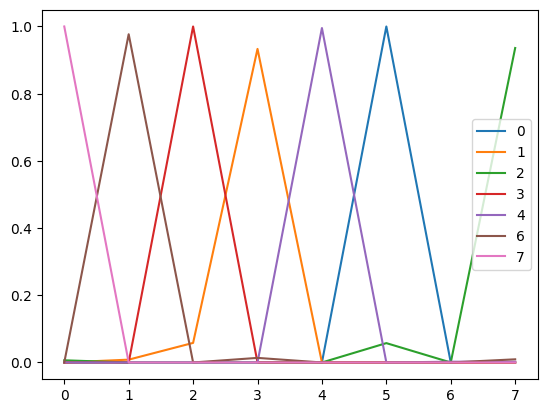

In [15]:
# predict the images
from tqdm import tqdm

predictions = []
loaded_model.eval()

with torch.no_grad():

    for image in tqdm(all_images):
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0) # shape: [1, 80, 80, 1]
        image = image.permute(0, 3, 1, 2)  # now shape: [1, 1, 80, 80]

        prediction = loaded_model(image.to('mps'))

        # apply softmax
        #prediction = nn.Softmax(dim=1)(
        #    prediction
        #)

        predictions.append(prediction.cpu().detach().numpy())

predictions = np.concatenate(predictions)
#print(predictions.shape)


# for each id of unique ids, get the average prediction
unique_ids = np.unique(all_ids)
average_predictions = []

for id in unique_ids:
    indexes = np.where(all_ids == id)
    average_prediction = np.mean(predictions[indexes], axis=0)
    average_predictions.append(average_prediction)

average_predictions = np.array(average_predictions)
#print(average_predictions)

for i, id in enumerate(unique_ids):
    plt.plot(average_predictions[i], label=id)
plt.legend()


### TF Predictions

100%|██████████| 100/100 [00:04<00:00, 21.36it/s]

(100, 8)
[[3.5862786e-06 1.0323935e-31 1.2718246e-32 4.6664518e-33 1.1356686e-20
  9.9999148e-01 1.5421301e-31 4.9872738e-06]
 [1.0239735e-19 1.2386045e-02 5.9671499e-02 9.2780417e-01 2.7118566e-18
  4.8432505e-15 1.3837722e-04 1.5758341e-09]
 [3.0231050e-03 1.9535911e-08 1.3156538e-16 6.5457753e-16 3.7811733e-07
  4.3387327e-02 1.7953874e-11 9.5358920e-01]
 [0.0000000e+00 3.0463404e-33 1.0000000e+00 1.3333771e-15 0.0000000e+00
  0.0000000e+00 8.8356199e-18 0.0000000e+00]
 [1.6448814e-04 7.4897688e-09 6.8210142e-08 3.3931424e-11 9.9097198e-01
  4.5280426e-06 5.5119996e-03 3.3469226e-03]
 [1.1728470e-11 9.8418075e-01 2.0938428e-06 8.4030395e-03 5.4340137e-13
  2.7274575e-08 7.2956802e-10 7.4139610e-03]
 [1.0000000e+00 2.7710487e-33 3.5879520e-34 3.1754942e-34 3.7921247e-10
  2.0036733e-08 9.2149059e-34 4.5026691e-13]]


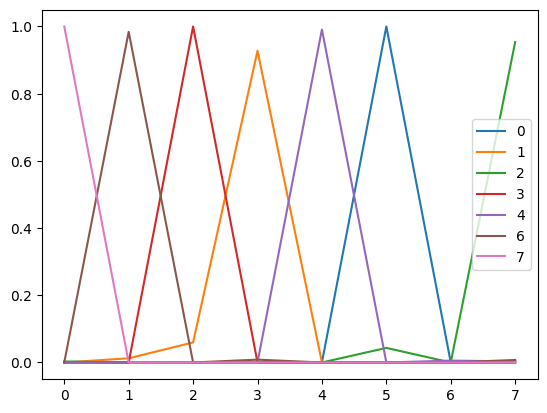

In [13]:
# predict the images using the tensorflow model
from tqdm import tqdm

predictions = []

for image in tqdm(all_images):
    image = image.reshape(1, 80, 80, 1)
    prediction = tf_model.predict(image, verbose=0)
    predictions.append(prediction)

predictions = np.concatenate(predictions)
print(predictions.shape)

# for each id of unique ids, get the average prediction
unique_ids = np.unique(all_ids)
average_predictions = []

for id in unique_ids:
    indexes = np.where(all_ids == id)
    average_prediction = np.mean(predictions[indexes], axis=0)
    average_predictions.append(average_prediction)

average_predictions = np.array(average_predictions)
print(average_predictions)

for i, id in enumerate(unique_ids):
    plt.plot(average_predictions[i], label=id)
plt.legend()

### Testing some custom PyTorch implementations

In [121]:
class V100Model_Debug(nn.Module):
    def __init__(self, image_width, image_height, channels, num_classes, padding='valid'):
        super(V100Model_Debug, self).__init__()
        self.input_scaling = InputScaling()
        pad = 0 if padding == 'valid' else 2
        self.conv1 = nn.Conv2d(channels, 16, kernel_size=5, padding=pad)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout2d(0.25)
        self.conv2 = nn.Conv2d(16, 64, kernel_size=5, padding=pad)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.drop2 = nn.Dropout2d(0.25)
        self.conv3 = nn.Conv2d(64, 100, kernel_size=5, padding=pad)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)
        self.drop3 = nn.Dropout2d(0.25)
        self.flatten = nn.Flatten()
        # Compute flattened dim via a dummy pass
        with torch.no_grad():
            dummy = torch.zeros((1, channels, image_height, image_width))
            dummy, _ = self._forward_conv(dummy)
        fc_input_dim = dummy.view(dummy.size(0), -1).size(1)
        self.fc1 = nn.Linear(fc_input_dim, 100)
        self.relu_fc1 = nn.ReLU()
        self.drop_fc1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(100, num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def _forward_conv(self, x):
        activations = {}
        x = self.input_scaling(x)
        activations['input_scaling'] = x.clone().detach()
        
        x = self.conv1(x)
        activations['conv1'] = x.clone().detach()
        x = self.relu1(x)
        activations['relu1'] = x.clone().detach()
        x = self.pool1(x)
        activations['pool1'] = x.clone().detach()
        x = self.drop1(x)
        activations['drop1'] = x.clone().detach()
        
        x = self.conv2(x)
        activations['conv2'] = x.clone().detach()
        x = self.relu2(x)
        activations['relu2'] = x.clone().detach()
        x = self.pool2(x)
        activations['pool2'] = x.clone().detach()
        x = self.drop2(x)
        activations['drop2'] = x.clone().detach()
        
        x = self.conv3(x)
        activations['conv3'] = x.clone().detach()
        x = self.relu3(x)
        activations['relu3'] = x.clone().detach()
        x = self.pool3(x)
        activations['pool3'] = x.clone().detach()
        x = self.drop3(x)
        activations['drop3'] = x.clone().detach()
        return x, activations

    def forward(self, x, return_activations=False):
        x, acts = self._forward_conv(x)
        x = self.flatten(x)
        acts['flatten'] = x.clone().detach()
        x = self.fc1(x)
        acts['fc1'] = x.clone().detach()
        x = self.relu_fc1(x)
        acts['relu_fc1'] = x.clone().detach()
        x = self.drop_fc1(x)
        acts['drop_fc1'] = x.clone().detach()
        x = self.fc2(x)
        acts['fc2'] = x.clone().detach()
        x = self.softmax(x)
        acts['softmax'] = x.clone().detach()
        if return_activations:
            return x, acts
        return x

def load_weights_pt(model, weights_dict):
    """
    Loads weights from a dictionary (with keys corresponding to the Keras layer index)
    into the corresponding PyTorch model layers.
    
    Expected mapping:
      - Key 1: Conv2D(16,5) weights → model.conv1
      - Key 4: Conv2D(64,5) weights → model.conv2
      - Key 7: Conv2D(100,5) weights → model.conv3
      - Key 11: Dense(100) weights → model.fc1
      - Key 13: Dense(num_classes) weights → model.fc2
    """
    mapping = {
        1: model.conv1,
        4: model.conv2,
        7: model.conv3,
        11: model.fc1,
        13: model.fc2
    }
    for k, layer in mapping.items():
        wlist = weights_dict[k]
        print(f"Loading weights for Keras layer {k} into {layer}")
        if isinstance(layer, nn.Conv2d):
            # Keras Conv2D kernel: (H, W, in_channels, out_channels)
            # PyTorch expects: (out_channels, in_channels, H, W)
            kernel = wlist[0]
            print("Original conv kernel shape:", kernel.shape)
            expected_orig_shape = (layer.weight.data.shape[2], layer.weight.data.shape[3],
                                   layer.weight.data.shape[1], layer.weight.data.shape[0])
            print("Expected Keras conv kernel shape (approx):", expected_orig_shape)
            kernel_transposed = np.transpose(kernel, (3, 2, 0, 1))
            print("Transposed conv kernel shape:", kernel_transposed.shape,
                  "Expected PyTorch shape:", layer.weight.data.shape)
            layer.weight.data.copy_(torch.from_numpy(kernel_transposed))
            if len(wlist) > 1 and layer.bias is not None:
                print("Loading conv bias shape:", wlist[1].shape, "expected:", layer.bias.data.shape)
                layer.bias.data.copy_(torch.from_numpy(wlist[1]))
        elif isinstance(layer, nn.Linear):
            # Keras Dense kernel is normally stored as (in_features, out_features).
            kernel = wlist[0]
            print("Original dense kernel shape:", kernel.shape)
            # Expected Keras shape is (layer.in_features, layer.out_features)
            expected_keras_shape = (layer.in_features, layer.out_features)
            expected_pt_shape = (layer.out_features, layer.in_features)
            if kernel.shape == expected_keras_shape:
                print("Kernel shape matches expected Keras shape", expected_keras_shape,
                      "; transposing to", expected_pt_shape)
                kernel_transposed = np.transpose(kernel)#, (1, 0))
            elif kernel.shape == expected_pt_shape:
                print("Kernel shape already matches expected PyTorch shape", expected_pt_shape,
                      "; no transposition needed")
                kernel_transposed = kernel
            else:
                raise ValueError(f"Unexpected dense kernel shape: {kernel.shape} "
                                 f"(expected {expected_keras_shape} or {expected_pt_shape})")
            print("Dense kernel final shape:", kernel_transposed.shape,
                  "Expected PyTorch shape:", layer.weight.data.shape)
            layer.weight.data.copy_(torch.from_numpy(kernel_transposed))
            if len(wlist) > 1 and layer.bias is not None:
                print("Loading dense bias shape:", wlist[1].shape, "expected:", layer.bias.data.shape)
                # For biases, just copy as is
                layer.bias.data.copy_(torch.from_numpy(wlist[1]))
        else:
            print(f"Warning: Weight loading not implemented for layer type {type(layer)}")

# Example usage:
model_pt = V100Model_Debug(80, 80, 1, 8, padding='valid')
load_weights_pt(model_pt, saved_weights)
model_pt.eval()

#dummy_input = torch.zeros((1, 1, 80, 80)) + 125  # simulate an image in 0-255 range
dummy_input = torch.tensor(np.transpose(np.copy(all_images[0]), (2, 0, 1)), dtype=torch.float32).unsqueeze(0)
print ("dummy_input", dummy_input.shape)
with torch.no_grad():
    output, activations = model_pt(dummy_input, return_activations=True)

for key, act in activations.items():
    print(f"{key}: shape {act.shape}, mean {act.mean().item():.4f}, std {act.std().item():.4f}")
print(output)

Loading weights for Keras layer 1 into Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
Original conv kernel shape: (5, 5, 1, 16)
Expected Keras conv kernel shape (approx): (5, 5, 1, 16)
Transposed conv kernel shape: (16, 1, 5, 5) Expected PyTorch shape: torch.Size([16, 1, 5, 5])
Loading conv bias shape: (16,) expected: torch.Size([16])
Loading weights for Keras layer 4 into Conv2d(16, 64, kernel_size=(5, 5), stride=(1, 1))
Original conv kernel shape: (5, 5, 16, 64)
Expected Keras conv kernel shape (approx): (5, 5, 16, 64)
Transposed conv kernel shape: (64, 16, 5, 5) Expected PyTorch shape: torch.Size([64, 16, 5, 5])
Loading conv bias shape: (64,) expected: torch.Size([64])
Loading weights for Keras layer 7 into Conv2d(64, 100, kernel_size=(5, 5), stride=(1, 1))
Original conv kernel shape: (5, 5, 64, 100)
Expected Keras conv kernel shape (approx): (5, 5, 64, 100)
Transposed conv kernel shape: (100, 64, 5, 5) Expected PyTorch shape: torch.Size([100, 64, 5, 5])
Loading conv bias shape: (

In [100]:
import tensorflow as tf
import numpy as np

def get_tf_intermediate_activations(model, input_data):
    """
    Given a Keras model and input data, returns a dictionary mapping layer names
    to their output activations.
    """
    # Create a new model whose outputs are the outputs of all layers that have an output attribute.
    layer_outputs = []
    layer_names = []
    for layer in model.layers:
        # Only include layers that have a defined output (skip Input layers, etc.)
        if hasattr(layer, 'output'):
            layer_outputs.append(layer.output)
            layer_names.append(layer.name)
    
    intermediate_model = tf.keras.Model(inputs=model.input, outputs=layer_outputs)
    outputs = intermediate_model.predict(input_data)
    
    activations = dict(zip(layer_names, outputs))
    return activations, outputs

# Example usage with your TF model:
# Assume tf_model is your loaded Keras model and dummy_input_tf is a NumPy array with shape (1,80,80,1)
#dummy_input_tf = np.random.uniform(0, 255, (1, 80, 80, 1)).astype(np.float32)
dummy_input_tf = np.copy(all_images[0][np.newaxis, ...]).astype(np.float32)
tf_activations, outputs = get_tf_intermediate_activations(tf_model, dummy_input_tf)

for name, act in tf_activations.items():
    print(f"TF layer {name}: shape {act.shape}, mean {act.mean():.4f}, std {act.std():.4f}")

print(outputs[-1])

1/1 [==============================] - 0s 88ms/step
TF layer lambda_1: shape (1, 80, 80, 1), mean -0.9709, std 0.1356
TF layer conv2d_1: shape (1, 76, 76, 16), mean 0.0015, std 0.0157
TF layer max_pooling2d_1: shape (1, 38, 38, 16), mean 0.0025, std 0.0214
TF layer spatial_dropout2d_1: shape (1, 38, 38, 16), mean 0.0025, std 0.0214
TF layer conv2d_2: shape (1, 34, 34, 64), mean 0.0045, std 0.0257
TF layer max_pooling2d_2: shape (1, 17, 17, 64), mean 0.0083, std 0.0410
TF layer spatial_dropout2d_2: shape (1, 17, 17, 64), mean 0.0083, std 0.0410
TF layer conv2d_3: shape (1, 13, 13, 100), mean 0.0101, std 0.0964
TF layer max_pooling2d_3: shape (1, 6, 6, 100), mean 0.0286, std 0.1711
TF layer spatial_dropout2d_3: shape (1, 6, 6, 100), mean 0.0286, std 0.1711
TF layer flatten_1: shape (1, 3600), mean 0.0286, std 0.1711
TF layer dense_1: shape (1, 100), mean 1.1600, std 2.3977
TF layer dropout_1: shape (1, 100), mean 1.1600, std 2.3977
TF layer dense_2: shape (1, 8), mean 0.1250, std 0.3307


In [125]:
mapping = {
    "lambda_1": "input_scaling",    # TF -> PyTorch
    "conv2d_1": "conv1",
    "max_pooling2d_1": "pool1",
    "spatial_dropout2d_1": "drop1",
    "conv2d_2": "conv2",
    "max_pooling2d_2": "pool2",
    "spatial_dropout2d_2": "drop2",
    "conv2d_3": "conv3",
    "max_pooling2d_3": "pool3",
    "spatial_dropout2d_3": "drop3",
    "flatten_1": "flatten",
    "dense_1": "relu_fc1",
    "dropout_1": "drop_fc1",
    "dense_2": "softmax"
}

def compare_activations(tf_acts, torch_acts, mapping):
    for tf_name, torch_name in mapping.items():
        if tf_name in tf_acts and torch_name in torch_acts:
            tf_act = tf_acts[tf_name]
            torch_act = torch_acts[torch_name]
            print(f"Comparing TF layer {tf_name} vs PyTorch module {torch_name}:")
            print(f"  TF shape: {tf_act.shape}, mean: {tf_act.mean():.4f}, std: {tf_act.std():.4f}")
            print(f"  Torch shape: {torch_act.shape}, mean: {torch_act.mean():.4f}, std: {torch_act.std():.4f}")
        else:
            print(f"Mapping {tf_name}->{torch_name} not found in both activations.")

# Now call compare_activations with the dictionaries you obtained:
compare_activations(tf_activations, activations, mapping)

Comparing TF layer lambda_1 vs PyTorch module input_scaling:
  TF shape: (1, 80, 80, 1), mean: -0.9709, std: 0.1356
  Torch shape: torch.Size([1, 1, 80, 80]), mean: -0.9709, std: 0.1356
Comparing TF layer conv2d_1 vs PyTorch module conv1:
  TF shape: (1, 76, 76, 16), mean: 0.0015, std: 0.0157
  Torch shape: torch.Size([1, 16, 76, 76]), mean: -0.7928, std: 1.1555
Comparing TF layer max_pooling2d_1 vs PyTorch module pool1:
  TF shape: (1, 38, 38, 16), mean: 0.0025, std: 0.0214
  Torch shape: torch.Size([1, 16, 38, 38]), mean: 0.0025, std: 0.0214
Comparing TF layer spatial_dropout2d_1 vs PyTorch module drop1:
  TF shape: (1, 38, 38, 16), mean: 0.0025, std: 0.0214
  Torch shape: torch.Size([1, 16, 38, 38]), mean: 0.0025, std: 0.0214
Comparing TF layer conv2d_2 vs PyTorch module conv2:
  TF shape: (1, 34, 34, 64), mean: 0.0045, std: 0.0257
  Torch shape: torch.Size([1, 64, 34, 34]), mean: -0.1422, std: 0.2277
Comparing TF layer max_pooling2d_2 vs PyTorch module pool2:
  TF shape: (1, 17, 17

In [84]:
import tensorflow as tf
import numpy as np

def get_tf_intermediate_activations(model, input_data):
    """
    Given a Keras model and input data, returns a dictionary mapping layer names
    to their output activations.
    """
    # Create a new model whose outputs are the outputs of all layers that have an output attribute.
    layer_outputs = []
    layer_names = []
    for layer in model.layers:
        # Only include layers that have a defined output (skip Input layers, etc.)
        if hasattr(layer, 'output'):
            layer_outputs.append(layer.output)
            layer_names.append(layer.name)
    
    intermediate_model = tf.keras.Model(inputs=model.input, outputs=layer_outputs)
    outputs = intermediate_model.predict(input_data)
    
    activations = dict(zip(layer_names, outputs))
    return activations

# Example usage with your TF model:
# Assume tf_model is your loaded Keras model and dummy_input_tf is a NumPy array with shape (1,80,80,1)
dummy_input_tf = np.random.uniform(0, 255, (1, 80, 80, 1)).astype(np.float32)
tf_activations = get_tf_intermediate_activations(tf_model, dummy_input_tf)

for name, act in tf_activations.items():
    print(f"TF layer {name}: shape {act.shape}, mean {act.mean():.4f}, std {act.std():.4f}")

import torch

def get_torch_intermediate_activations(model, input_tensor):
    """
    Given a PyTorch model and input tensor, returns a dictionary mapping layer names
    to their output activations using forward hooks.
    """
    activations = {}

    def hook_fn(module, input, output):
        # Use the module's name (if available) or its class name plus id.
        name = module.__class__.__name__ + "_" + str(id(module))
        activations[name] = output.detach().cpu().numpy()

    hooks = []
    # Register hooks on leaf modules (i.e. modules that do not contain children)
    for name, module in model.named_modules():
        if len(list(module.children())) == 0:
            hook = module.register_forward_hook(hook_fn)
            hooks.append(hook)

    model.eval()
    with torch.no_grad():
        _ = model(input_tensor)

    # Remove hooks
    for hook in hooks:
        hook.remove()
        
    return activations

# Example usage with your PyTorch model:
# Assume model_pt is your PyTorch model and dummy_input_pt is a tensor of shape (1,1,80,80)
dummy_input_pt = torch.rand((1, 1, 80, 80)) * 255  # simulate an image in 0-255 range
torch_activations = get_torch_intermediate_activations(model, dummy_input_pt)

# Print out some stats for each activation:
for name, act in torch_activations.items():
    print(f"PyTorch module {name}: shape {act.shape}, mean {act.mean():.4f}, std {act.std():.4f}")

1/1 [==============================] - 0s 256ms/step
TF layer lambda_1: shape (1, 80, 80, 1), mean 0.0097, std 0.5771
TF layer conv2d_1: shape (1, 76, 76, 16), mean 0.1566, std 0.2651
TF layer max_pooling2d_1: shape (1, 38, 38, 16), mean 0.3493, std 0.3450
TF layer spatial_dropout2d_1: shape (1, 38, 38, 16), mean 0.3493, std 0.3450
TF layer conv2d_2: shape (1, 34, 34, 64), mean 0.4371, std 1.3546
TF layer max_pooling2d_2: shape (1, 17, 17, 64), mean 0.7053, std 1.7676
TF layer spatial_dropout2d_2: shape (1, 17, 17, 64), mean 0.7053, std 1.7676
TF layer conv2d_3: shape (1, 13, 13, 100), mean 0.0430, std 0.6217
TF layer max_pooling2d_3: shape (1, 6, 6, 100), mean 0.1166, std 1.1007
TF layer spatial_dropout2d_3: shape (1, 6, 6, 100), mean 0.1166, std 1.1007
TF layer flatten_1: shape (1, 3600), mean 0.1166, std 1.1007
TF layer dense_1: shape (1, 100), mean 8.1095, std 8.8916
TF layer dropout_1: shape (1, 100), mean 8.1095, std 8.8916
TF layer dense_2: shape (1, 8), mean 0.1250, std 0.3307


TypeError: 'numpy.int32' object is not callable

### Streamlined interface

In [ ]:
import json
import keras
from keras.models import model_from_json
import tensorflow as tf
import tf2onnx
from onnx2pytorch import ConvertModel
import torch
import numpy as np

def scaling_fn(x):
    """Custom scaling function to replace Lambda layers."""
    return x / 127.5 - 1.0

def convert_keras_to_torch(json_path, weights_path=None, image_width=None, image_height=None, channels=None, output_path=None):
    """
    Converts a Keras model stored in JSON format to a frozen PyTorch model via ONNX and TorchScript.
    
    Optionally loads model weights from a provided NumPy .npz file.
    
    Parameters:
      json_path (str): Path to the Keras JSON model file.
      weights_path (str, optional): Path to a NumPy (.npz) file containing model weights.
      image_width (int, optional): Input image width. If None, extracted from the model.
      image_height (int, optional): Input image height. If None, extracted from the model.
      channels (int, optional): Number of input channels. If None, extracted from the model.
      output_path (str, optional): If provided, the final TorchScript model is saved at this path.
      
    Returns:
      torch.jit.ScriptModule: The frozen PyTorch model.
      
    Raises:
      ValueError: If the input dimensions cannot be determined from the JSON file and are not provided.
    """
    # Load and update the model configuration.
    with open(json_path, "r") as f:
        model_dict = json.load(f)
    
    # If any input dimension is not provided, try to extract it from the JSON.
    if image_width is None or image_height is None or channels is None:
        found = False
        for layer in model_dict["config"]["layers"]:
            config = layer.get("config", {})
            if "batch_input_shape" in config:
                batch_input_shape = config["batch_input_shape"]
                # Determine the data format; default to channels_last.
                data_format = config.get("data_format", "channels_last")
                if data_format == "channels_last":
                    # batch_input_shape is [None, height, width, channels]
                    image_height = batch_input_shape[1]
                    image_width  = batch_input_shape[2]
                    channels     = batch_input_shape[3]
                else:
                    # For channels_first: [None, channels, height, width]
                    channels     = batch_input_shape[1]
                    image_height = batch_input_shape[2]
                    image_width  = batch_input_shape[3]
                found = True
                print(f"Automatically detected input dimensions: width={image_width}, height={image_height}, channels={channels}")
                break
        
        if not found or image_width is None or image_height is None or channels is None:
            raise ValueError("Could not determine input dimensions from the JSON file. Please provide image_width, image_height, and channels explicitly.")
    
    # Replace Lambda layer function with our custom scaling function.
    for layer in model_dict["config"]["layers"]:
        if layer["class_name"] == "Lambda":
            layer["config"]["function"] = "scaling_fn"
            layer["config"]["function_type"] = "raw"
            layer["config"]["arguments"] = {}
    new_json = json.dumps(model_dict)
    
    # Load and compile the Keras model.
    tf_model = model_from_json(new_json, custom_objects={"scaling_fn": scaling_fn})
    tf_model.compile(loss='categorical_crossentropy',
                     optimizer=keras.optimizers.Adam(),
                     metrics=['accuracy'])
    
    # Optionally, load model weights from a .npz file.
    if weights_path:
        with np.load(weights_path, allow_pickle=True) as npz:
            weights = npz['weights'].item()
            for i, layer in zip(range(len(tf_model.layers)), tf_model.layers):
                if i in weights:
                    layer.set_weights(weights[i])
        print(f"Weights loaded from: {weights_path}")
    
    # Convert the Keras model to ONNX.
    spec = (tf.TensorSpec(tf_model.input.shape, tf.float32, name="input"),)
    onnx_model, _ = tf2onnx.convert.from_keras(tf_model, input_signature=spec)
    
    # Convert ONNX to PyTorch.
    pytorch_model = ConvertModel(onnx_model)
    pytorch_model.eval()
    
    # Prepare a dummy input and freeze the model using TorchScript.
    dummy_input = torch.randn(1, channels, image_height, image_width)
    try:
        scripted_model = torch.jit.script(pytorch_model)
        print("Model scripted successfully.")
    except Exception as e:
        print("Scripting failed, falling back to tracing. Error:", e)
        scripted_model = torch.jit.trace(pytorch_model, dummy_input)
        print("Model traced successfully.")
    
    # Optionally, save the final TorchScript model.
    if output_path:
        torch.jit.save(scripted_model, output_path)
        print(f"TorchScript model saved at: {output_path}")
    
    return scripted_model, (image_width, image_height, channels)

if True: #__name__ == "__main__":
    # Paths to the Keras model and weights
    json_model_path = "/Users/tristan/Downloads/guppy_8_t56_d1_20200727_092850_weights.json"
    # the weights to be loaded
    weights_file_path = "/Users/tristan/Downloads/guppy_8_t56_d1_20200727_092850_weights.npz"          
    # (optional) Path to save the final TorchScript model
    output_model_path = "/Users/tristan/Downloads/guppy_8_t56_d1_20200727_092850_weights_model.pth"
    
    # Convert the Keras model and obtain the frozen PyTorch model.
    model, shape = convert_keras_to_torch(
        json_path=json_model_path,
        weights_path=weights_file_path,
        output_path=output_model_path
    )
    
    # Test the converted model with a dummy input. in the format (batch, channels, height, width)
    dummy_input = torch.randn(1, shape[-1], shape[1], shape[0])
    with torch.no_grad():
        output = model(dummy_input)
    print("Test output:", output)

Automatically detected input dimensions: width=80, height=80, channels=1


Weights loaded from: /Users/tristan/Downloads/guppy_8_t56_d1_20200727_092850_weights.npz
Scripting failed, falling back to tracing. Error: Compiled functions can't take variable number of arguments or use keyword-only arguments with defaults:
  File "/Users/tristan/miniforge3/envs/jupyter2/lib/python3.8/site-packages/onnx2pytorch/convert/model.py", line 152
    def forward(self, *input_list, **input_dict):
                                    ~~~~~~~~~~~ <--- HERE
        if len(input_list) > 0 and len(input_dict) > 0:
            raise ValueError(



/Users/tristan/miniforge3/envs/jupyter2/lib/python3.8/site-packages/onnx2pytorch/convert/model.py:163: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if not self.experimental and inputs[0].shape[self.batch_dim] > 1:
/Users/tristan/miniforge3/envs/jupyter2/lib/python3.8/site-packages/onnx2pytorch/operations/reshape.py:28: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  shape = [x if x != 0 else input.size(i) for i, x in enumerate(shape)]
/Users/tristan/miniforge3/envs/jupyter2/lib/python3.8/site-packages/onnx2pytorch/operations/reshape.py:28: TracerWarning: Converting a tensor to a Python boolean

Model traced successfully.
TorchScript model saved at: /Users/tristan/Downloads/guppy_8_t56_d1_20200727_092850_weights_model.pth
Test output: tensor([[0.0502, 0.1766, 0.1255, 0.1373, 0.0645, 0.0754, 0.1994, 0.1710]])


100%|██████████| 100/100 [00:03<00:00, 26.45it/s]


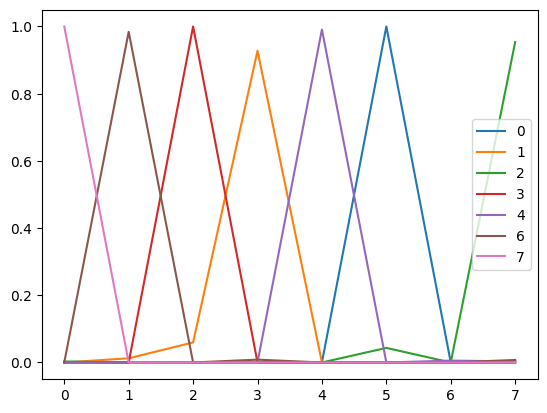

In [17]:
# predict the images
from tqdm import tqdm

predictions = []
model.eval()

with torch.no_grad():

    for image in tqdm(all_images):
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0) # shape: [1, 80, 80, 1]
        image = image.permute(0, 3, 1, 2)  # now shape: [1, 1, 80, 80]

        prediction = model(image)

        # apply softmax
        #prediction = nn.Softmax(dim=1)(
        #    prediction
        #)

        predictions.append(prediction.cpu().detach().numpy())

predictions = np.concatenate(predictions)
#print(predictions.shape)


# for each id of unique ids, get the average prediction
unique_ids = np.unique(all_ids)
average_predictions = []

for id in unique_ids:
    indexes = np.where(all_ids == id)
    average_prediction = np.mean(predictions[indexes], axis=0)
    average_predictions.append(average_prediction)

average_predictions = np.array(average_predictions)
#print(average_predictions)

for i, id in enumerate(unique_ids):
    plt.plot(average_predictions[i], label=id)
plt.legend()
